In [1]:
!pip install datasets
!pip install patchify
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00


In [2]:
!ls ./drive/MyDrive

 232020MAT1__MARTI_PEREZ_firmado.pdf			       Justificante_17572749.pdf
 26579566F_FÉLIX_MARTÍ_ciudadano_1644506302753.p12	       Orux
 Bd							       Pasta_Tour.docx
'Colab Notebooks'					      'Personal_monthly_budget .xlsx'
 Dataset						       Resume.gdoc
 Docubox_19-09-2022_1231.pdf				      'Untitled document.gdoc'
 felix-Protocolo-de-actuacion-Certificado-Entorno-Seguro.pdf


In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import torch
import glob
import json
from PIL import Image
from patchify import patchify

In [4]:
def json_to_mask(json_file, image_shape=(750, 1000)):
    mask = np.zeros(image_shape, dtype=np.uint8)
    #print(mask.shape)
    #print(json_file[0]['content'])
    pts = []
    if len(json_file[0]['content']) == 0:
        return mask
    for point in json_file[0]['content']:
        if json_file[0]['contentType'] == 'polygon':
            #print(point['x'], point['y'])
            x,y = int(point['x']), int(point['y'])
            #print(mask[y,x])
            pts.append([x,y])
    #print(mask.shape)
    pts = np.array(pts, np.int32)
    mask = cv2.fillPoly(mask, pts=[pts], color=255)
    return mask

In [5]:
image_files = sorted(glob.glob("./drive/MyDrive/Dataset/images/*.jpg"))
mask_files = sorted(glob.glob("./drive/MyDrive/Dataset/masks/*.json"))

In [6]:
from PIL import Image

images = [cv2.imread(file) for file in image_files]
masks = [json_to_mask(json.load(open(file))) for file in mask_files]

images = np.array(images)
masks = np.array(masks)

In [7]:
print(images.shape)
print(masks.shape)
#print(images[0].dtype)
#print(masks[0].dtype)

(930, 750, 1000, 3)
(930, 750, 1000)


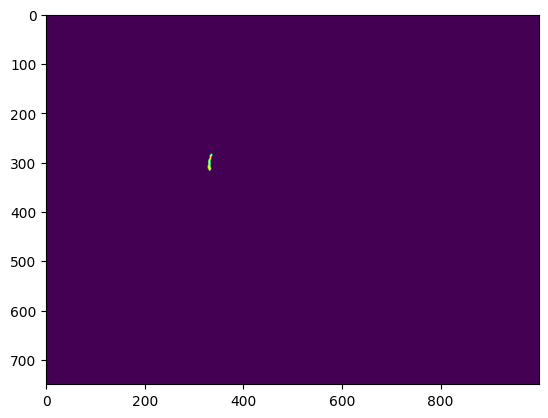

In [8]:
#plt.imshow(images[0])
plt.imshow(masks[0])

In [9]:
def patchify_dataset(images, patch_size=(256,256, 3), step=256):
    #Return patchified images and masks as numpy arrays
    patch_images = []
    for i in range(images.shape[0]):
        #print(images[i].shape)
        #print(mask.shape)
        patch_images.append(patchify(images[i], patch_size, step))
        #patch_masks.append(patchify(mask, patch_size, step))
    patch_images = np.array(patch_images)
    #patch_masks = np.array(patch_masks)
    if len(patch_size) == 3:
      patch_images = np.reshape(patch_images, (-1, patch_size[0], patch_size[1], patch_size[2]))
    elif len(patch_size) == 2:
      patch_images = np.reshape(patch_images, (-1, patch_size[0], patch_size[1]))
    return patch_images

In [10]:
#patch_images, patch_masks = patchify_dataset(images, masks)
patch_images = patchify_dataset(images)
patch_masks = patchify_dataset(masks, patch_size=(256,256))
print(patch_images.shape)
print(patch_masks.shape)

(5580, 256, 256, 3)
(5580, 256, 256)


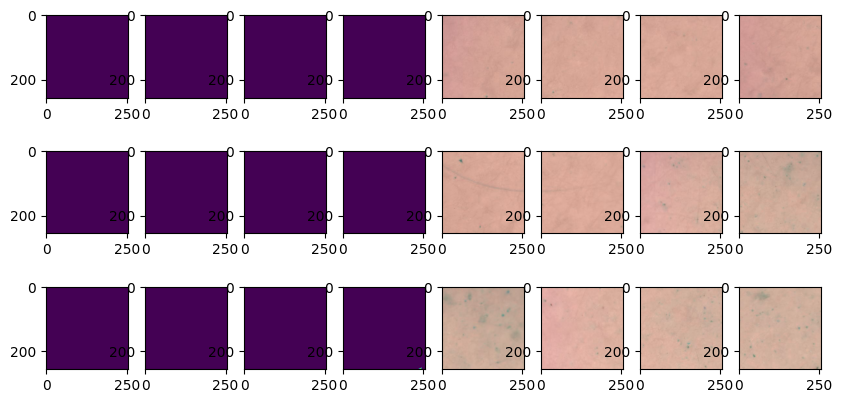

In [11]:
fig, axes = plt.subplots(3, 8, figsize=(10, 5))
i=12*4
axes[0][0].imshow(patch_masks[0+i])
axes[0][1].imshow(patch_masks[1+i])
axes[0][2].imshow(patch_masks[2+i])
axes[0][3].imshow(patch_masks[3+i])
axes[0][4].imshow(patch_images[0+i])
axes[0][5].imshow(patch_images[1+i])
axes[0][6].imshow(patch_images[2+i])
axes[0][7].imshow(patch_images[3+i])
axes[1][0].imshow(patch_masks[4+i])
axes[1][1].imshow(patch_masks[5+i])
axes[1][2].imshow(patch_masks[6+i])
axes[1][3].imshow(patch_masks[7+i])
axes[1][4].imshow(patch_images[4+i])
axes[1][5].imshow(patch_images[5+i])
axes[1][6].imshow(patch_images[6+i])
axes[1][7].imshow(patch_images[7+i])
axes[2][0].imshow(patch_masks[8+i])
axes[2][1].imshow(patch_masks[9+i])
axes[2][2].imshow(patch_masks[10+i])
axes[2][3].imshow(patch_masks[11+i])
axes[2][4].imshow(patch_images[8+i])
axes[2][5].imshow(patch_images[9+i])
axes[2][6].imshow(patch_images[10+i])
axes[2][7].imshow(patch_images[11+i])

In [12]:
print(patch_masks[0].max())

0


In [13]:
valid_indices = [i for i, patch_mask in enumerate(patch_masks) if patch_mask.max() != 0]
filtered_images = patch_images[valid_indices]
filtered_masks = patch_masks[valid_indices]
print("Image shape:", filtered_images.shape)
print("Mask shape:", filtered_masks.shape)

#filtered_images = patch_images
#filtered_masks = patch_masks

Image shape: (792, 256, 256, 3)
Mask shape: (792, 256, 256)


In [14]:
dataset_dict = {
    "image": [Image.fromarray(image) for image in filtered_images],
    "mask": [Image.fromarray(mask, mode='L') for mask in filtered_masks]
}

In [15]:
from datasets import Dataset

dataset = Dataset.from_dict(dataset_dict)

In [16]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 792
})

736


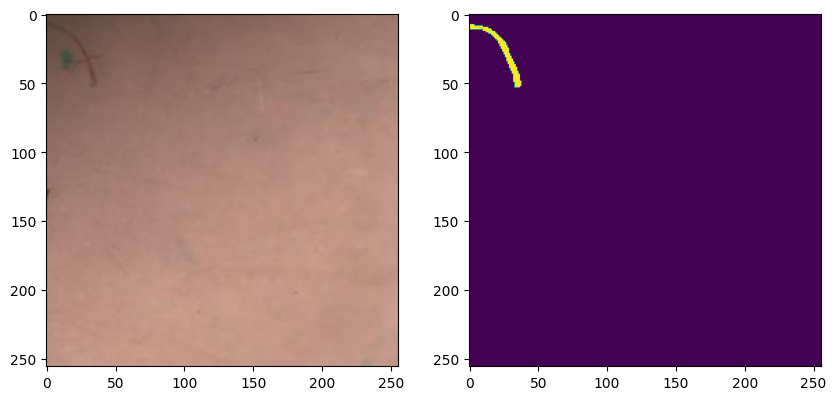

In [17]:
img_num = random.randint(0, filtered_images.shape[0]-1)
print(img_num)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(dataset[img_num]["image"])
axes[1].imshow(dataset[img_num]["mask"])

In [18]:
dataset.save_to_disk("train_929img_new")

Saving the dataset (0/1 shards):   0%|          | 0/792 [00:00<?, ? examples/s]

In [19]:
def get_bounding_box(ground_truth_map):
    #print(ground_truth_map)
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [20]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):

    item = self.dataset[idx]
    #print(item)
    image = item["image"]

    if type(item["mask"]) == list:
      ground_truth_mask = [np.array(i) for i in item["mask"]]
      prompt = [get_bounding_box(mask) for mask in ground_truth_mask]
    else:
      ground_truth_mask = np.array(item["mask"], np.float32)
      prompt = get_bounding_box(ground_truth_mask)



    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    #inputs = self.processor(image, input_boxes=[[]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [21]:
from transformers import SamProcessor, SamModel

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [22]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)


In [23]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 792
})

In [24]:
example = train_dataset[0]
for k,v in example.items():
  print("key:", k, "shape:", v.shape)

key: pixel_values shape: torch.Size([3, 1024, 1024])
key: original_sizes shape: torch.Size([2])
key: reshaped_input_sizes shape: torch.Size([2])
key: input_boxes shape: torch.Size([1, 4])
key: ground_truth_mask shape: (256, 256)


In [25]:
print(example)

{'pixel_values': tensor([[[1.1529, 1.1529, 1.1529,  ..., 1.4612, 1.4612, 1.4612],
         [1.1529, 1.1529, 1.1529,  ..., 1.4612, 1.4612, 1.4612],
         [1.1700, 1.1700, 1.1700,  ..., 1.4612, 1.4612, 1.4612],
         ...,
         [1.3584, 1.3584, 1.3584,  ..., 1.4269, 1.4269, 1.4269],
         [1.3584, 1.3584, 1.3584,  ..., 1.4269, 1.4269, 1.4269],
         [1.3584, 1.3584, 1.3584,  ..., 1.4269, 1.4269, 1.4269]],

        [[0.6254, 0.6254, 0.6254,  ..., 0.8004, 0.8004, 0.8004],
         [0.6254, 0.6254, 0.6254,  ..., 0.8004, 0.8004, 0.8004],
         [0.6254, 0.6254, 0.6254,  ..., 0.8004, 0.8004, 0.8004],
         ...,
         [0.6954, 0.6954, 0.6954,  ..., 0.7304, 0.7304, 0.7304],
         [0.6954, 0.6954, 0.6954,  ..., 0.7304, 0.7304, 0.7304],
         [0.6954, 0.6954, 0.6954,  ..., 0.7304, 0.7304, 0.7304]],

        [[0.5834, 0.5834, 0.5834,  ..., 0.7751, 0.7751, 0.7751],
         [0.5834, 0.5834, 0.5834,  ..., 0.7751, 0.7751, 0.7751],
         [0.5834, 0.5834, 0.5834,  ..., 0

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print("key:", k, "shape:", v.shape)

key: pixel_values shape: torch.Size([2, 3, 1024, 1024])
key: original_sizes shape: torch.Size([2, 2])
key: reshaped_input_sizes shape: torch.Size([2, 2])
key: input_boxes shape: torch.Size([2, 4])
key: ground_truth_mask shape: torch.Size([2, 256, 256])


In [28]:
batch["ground_truth_mask"].shape


torch.Size([2, 256, 256])

In [29]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import torchmetrics

#Training loop
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

mean_losses = []
iou_metric = torchmetrics.classification.BinaryJaccardIndex(threshold=0.5).to(device)
iou_scores = []

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_iou_scores = []
    for batch in tqdm(train_dataloader):
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].unsqueeze(1).to(device),
                      multimask_output=False)

      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      binary_ground_truth_masks = (ground_truth_masks > 127.5).int()
      metric = iou_metric(predicted_masks, binary_ground_truth_masks.unsqueeze(1))        
      epoch_iou_scores.append(metric.item())

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
      epoch_losses.append(loss.item())

    iou_scores.append(mean(epoch_iou_scores))
    mean_losses.append(mean(epoch_losses))
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'Mean IoU score: {mean(epoch_iou_scores)}')

100%|██████████| 396/396 [07:08<00:00,  1.08s/it]


EPOCH: 0
Mean loss: -6189.115099926187


100%|██████████| 396/396 [07:16<00:00,  1.10s/it]


EPOCH: 1
Mean loss: -25029.397260415433


100%|██████████| 396/396 [07:16<00:00,  1.10s/it]


EPOCH: 2
Mean loss: -53012.05649820963


100%|██████████| 396/396 [07:16<00:00,  1.10s/it]


EPOCH: 3
Mean loss: -97147.50786490392


100%|██████████| 396/396 [07:17<00:00,  1.11s/it]


EPOCH: 4
Mean loss: -164487.18921638257


100%|██████████| 396/396 [07:18<00:00,  1.11s/it]


EPOCH: 5
Mean loss: -261370.19015595407


100%|██████████| 396/396 [07:23<00:00,  1.12s/it]


EPOCH: 6
Mean loss: -394395.35825293954


100%|██████████| 396/396 [07:32<00:00,  1.14s/it]


EPOCH: 7
Mean loss: -567902.7860834912


100%|██████████| 396/396 [07:04<00:00,  1.07s/it]


EPOCH: 8
Mean loss: -792155.5622336648


100%|██████████| 396/396 [06:54<00:00,  1.05s/it]

EPOCH: 9
Mean loss: -1070389.9681088226


In [ ]:
axes, fig = plt.subplots(1, 2, figsize=(10, 5))
fig[0].plot(mean_losses)
fig[0].set_title("Mean loss")
fig[1].plot(iou_scores)
fig[1].set_title("Mean IoU score")

In [32]:
torch.save(model.state_dict(), "./sam_929img_10e_checkpoint.pth")